# Задача моделирования дефолта по договору

## Импорт библиотек

In [1]:
#pip install category_encoders
#pip install pygini
#pip install feature_engine
#pip install scikit-optimize 

import pandas as pd
import seaborn as sns
import numpy as np
import math
import re
import sklearn
from numpy import percentile
from scipy.stats import ks_2samp, kstest
from matplotlib import pyplot as plt
from feature_engine.encoding import RareLabelEncoder
from category_encoders.woe import WOEEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.isotonic import IsotonicRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import calibration_curve
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from pygini import gini
from skopt import BayesSearchCV
from pandas import get_dummies
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay

import warnings
warnings.simplefilter("ignore")

## Функции

In [2]:
def data_outlier(data):
    """Функция определяет выбросы числовых признаков и строит датафрейм"""

    data_out = pd.DataFrame(data={'name': [], 'нижняя граница': [], 'верхняя граница': [], 'количество выбросов': []})
    
    df_copy = data.copy()
    numeric_f = df_copy.select_dtypes(include=['int64', 'float64']).columns.drop(['Credit Default']).to_list()
    
    for column in numeric_f:
        perc25 = percentile(df_copy[column].dropna(axis=0), 25)
        perc75 = percentile(df_copy[column].dropna(axis=0), 75)
        iqr = perc75 - perc25
        low_range = perc25 - 1.5 * iqr
        upper_range = perc75 + 1.5 * iqr
        out_count = df_copy.loc[((df_copy[column] < low_range) | 
                                 (df_copy[column] > upper_range)), column].count()

        to_append = [column, round(low_range, 2), round(upper_range, 2), out_count]
        data_out_length = len(data_out)
        data_out.loc[data_out_length] = to_append

    data_out = data_out.set_index('name')

    return data_out

In [3]:
def count_plot(var, data):
    """Функция строит countplot для признака с разделением по дефолту"""
    
    plt.figure(figsize=(5,7))
    sns.countplot(y=var, data=data, hue='Credit Default', order=data[var].value_counts().index)
    plt.show()

In [4]:
def hist_plot(var, data):
    """Функция строит histplot для признака с разделением по дефолту. Если признак имеет больше 100 уникальных
    значений, создается логарифм данного признака и строится долнительный histplot"""
    
    plt.figure(figsize=(15,5))
    sns.histplot(x=var, data=data, hue='Credit Default', multiple="stack")
    plt.show()  
    
    #Создаем логарифмическую переменную от исходной если количетсво уникальных значений больше 100
    if data[var].nunique() > 100:
        data_copy = data[[var, 'Credit Default']].copy()
        var_log = var +'_log'
        data_copy[var_log] = np.log(data_copy[var] + 1)
        
        plt.figure(figsize=(15,5))
        sns.histplot(x=var_log, data=data_copy, hue='Credit Default', multiple="stack")
        plt.show() 

In [5]:
# интервальный Джини --некорректный
def interval_gini_old(prb_list):
    """Функция считает значение Джини на 1000 бустреп выборках из 100 элементов и записывает значения в список"""
    
    gini_values = []
    
    for x in range(1000):
        gini_x = gini(np.random.choice(prb_list, size=100))
        gini_values.append(gini_x)
    
    return gini_values

In [158]:
def interval_gini(y_test, model_prb):
    """Функция считает индекс Джини на 1000 бустреп выборках из 100 элементов и записывает значения в список"""
    
    gini_values = []
    
    for x in range(1000):
        list_index = np.random.randint(len(y_test), size=100)
        roc_auc_val = roc_auc_score(y_test.values[list_index], lr_prb[list_index])
        gini_x = 2 * roc_auc_val - 1
        gini_values.append(gini_x)
    
    return gini_values


In [159]:
def plot_gini_interv(gini_x, gini_interv):
    """Функция строит график интервальных Джини и общее Джини модели"""
    
    plt.figure(figsize=(10,5))
    plt.hist(gini_interv, bins=20)
    plt.axvline(x=gini_x, color='orange', linestyle="--") 
    plt.text (gini_x, 100, gini_x)
    plt.title('Распределение коэффициентов Джини')
    plt.show()

In [165]:
def model_ks_test(model_prb, data):
    """Функция строит распределение кумулятивной функции скоринга и выводит значение теста КС"""
    
    data_copy = pd.DataFrame(zip(data['Credit Score'],model_prb), columns=['Scoring', 'probab_default'])
    data_copy['default'] = data_copy['probab_default'].apply(lambda x: 1 if x >= 0.5 else 0)

    #График
    plt.figure(figsize=(5,5))
    sns.ecdfplot(data=data_copy, x='Scoring', hue='default')
    plt.title("Cumulative function of Scoring")
    plt.show()

    #KS test
    good_scor = sorted(data_copy.loc[(data_copy['default']==0),'Scoring'].values)
    bad_scor = sorted(data_copy.loc[(data_copy['default']==1),'Scoring'].values)
    
    ks_result = ks_2samp(good_scor, bad_scor)
    print(f"Результат КС теста:")
    
    return ks_result

In [8]:
def calculate_psi(expected, actual, buckettype='bins', buckets=10, axis=0):
    '''Calculate the PSI (population stability index) across all variables
    Args:
       expected: numpy matrix of original values
       actual: numpy matrix of new values, same size as expected
       buckettype: type of strategy for creating buckets, bins splits into even splits, quantiles splits into quantile buckets
       buckets: number of quantiles to use in bucketing variables
       axis: axis by which variables are defined, 0 for vertical, 1 for horizontal
    Returns:
       psi_values: ndarray of psi values for each variable
    Author:
       Matthew Burke
       github.com/mwburke
       worksofchart.com
    '''

    def psi(expected_array, actual_array, buckets):
        '''Calculate the PSI for a single variable
        Args:
           expected_array: numpy array of original values
           actual_array: numpy array of new values, same size as expected
           buckets: number of percentile ranges to bucket the values into
        Returns:
           psi_value: calculated PSI value
        '''

        def scale_range (input, min, max):
            input += -(np.min(input))
            input /= np.max(input) / (max - min)
            input += min
            return input


        breakpoints = np.arange(0, buckets + 1) / (buckets) * 100

        if buckettype == 'bins':
            breakpoints = scale_range(breakpoints, np.min(expected_array), np.max(expected_array))
        elif buckettype == 'quantiles':
            breakpoints = np.stack([np.percentile(expected_array, b) for b in breakpoints])



        expected_percents = np.histogram(expected_array, breakpoints)[0] / len(expected_array)
        actual_percents = np.histogram(actual_array, breakpoints)[0] / len(actual_array)

        def sub_psi(e_perc, a_perc):
            '''Calculate the actual PSI value from comparing the values.
               Update the actual value to a very small number if equal to zero
            '''
            if a_perc == 0:
                a_perc = 0.0001
            if e_perc == 0:
                e_perc = 0.0001

            value = (e_perc - a_perc) * np.log(e_perc / a_perc)
            return(value)

        psi_value = np.sum(sub_psi(expected_percents[i], actual_percents[i]) for i in range(0, len(expected_percents)))

        return(psi_value)

    if len(expected.shape) == 1:
        psi_values = np.empty(len(expected.shape))
    else:
        psi_values = np.empty(expected.shape[axis])

    for i in range(0, len(psi_values)):
        if len(psi_values) == 1:
            psi_values = psi(expected, actual, buckets)
        elif axis == 0:
            psi_values[i] = psi(expected[:,i], actual[:,i], buckets)
        elif axis == 1:
            psi_values[i] = psi(expected[i,:], actual[i,:], buckets)

    return(psi_values)

In [170]:
def model_calibr_curve(model_name, model_prb, y_test, X_val, y_val, label=''):
    """Функция считает изотоническую калибровку для модели и выводит график сравнения"""
    
    #IsotonicRegression
    isotonic_regress = IsotonicRegression(y_min = 0, y_max = 1, out_of_bounds = 'clip').fit(model_prb, y_test)
    prb_isotonic_regress = isotonic_regress.predict(model_name.predict_proba(X_val)[:, 1])
    
    #Создаем calibration_curve моделей для сравнения
    prob_true_model, prob_pred_model = calibration_curve(y_test, model_prb, n_bins=10)
    prob_true_iso, prob_pred_iso = calibration_curve(y_val, prb_isotonic_regress, n_bins=10)
    
    #Строим график
    plt.figure(figsize=(7,7))
    plt.plot([0,1], [0,1], color='grey')
    l1 = plt.plot(prob_pred_model, prob_true_model, marker='o', label='initial_model')
    l2 = plt.plot(prob_pred_iso, prob_true_iso, marker='o', label='iso_model')
    plt.legend()
    plt.xlabel('Predicted probability')
    plt.ylabel('True probability in each bin')
    plt.show()

## Общие переменные

In [10]:
RANDOM_SEED = 42

## Загрузка датасета и предварительный просмотр

In [11]:
df = pd.read_csv('C:/Users/Files/GB_AA_DataScience/AA_test/train.csv')

In [12]:
df.sample(10)

,Id,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
3298,3298,Home Mortgage,NaN,< 1 year,0.0,7.0,11.7,281358.0,0.0,NaN,0.0,buy a car,Short Term,88968.0,23579.0,10143.0,NaN,0
1122,1122,Rent,788424.0,1 year,0.0,10.0,22.7,854700.0,0.0,13.0,0.0,debt consolidation,Short Term,99999999.0,323304.0,14651.0,716.0,0
7311,7311,Own Home,NaN,10+ years,0.0,15.0,16.1,466202.0,1.0,50.0,0.0,debt consolidation,Short Term,414480.0,315267.0,36824.0,NaN,0
732,732,Rent,558999.0,4 years,0.0,15.0,20.0,1246102.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,83942.0,12801.0,751.0,0
6323,6323,Home Mortgage,750880.0,NaN,0.0,10.0,33.5,528264.0,0.0,44.0,0.0,home improvements,Short Term,97812.0,327123.0,20336.0,731.0,0
5290,5290,Own Home,NaN,10+ years,0.0,27.0,21.5,1036530.0,0.0,13.0,0.0,debt consolidation,Long Term,449240.0,367916.0,17113.0,NaN,0
1162,1162,Rent,479275.0,2 years,0.0,12.0,9.7,310508.0,0.0,NaN,0.0,debt consolidation,Short Term,172040.0,219355.0,7828.0,730.0,0
2606,2606,Home Mortgage,7883442.0,9 years,0.0,22.0,31.3,2262436.0,0.0,5.0,0.0,debt consolidation,Short Term,608542.0,879263.0,60834.0,746.0,0
6504,6504,Home Mortgage,2255148.0,1 year,0.0,15.0,14.0,2933458.0,0.0,NaN,0.0,other,Short Term,565774.0,184946.0,12178.0,746.0,0
6348,6348,Own Home,741456.0,10+ years,0.0,8.0,17.3,649858.0,0.0,NaN,0.0,debt consolidation,Long Term,378290.0,363128.0,16312.0,686.0,0


In [13]:
df.shape

(7500, 18)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Id                            7500 non-null   int64  
 1   Home Ownership                7500 non-null   object 
 2   Annual Income                 5943 non-null   float64
 3   Years in current job          7129 non-null   object 
 4   Tax Liens                     7500 non-null   float64
 5   Number of Open Accounts       7500 non-null   float64
 6   Years of Credit History       7500 non-null   float64
 7   Maximum Open Credit           7500 non-null   float64
 8   Number of Credit Problems     7500 non-null   float64
 9   Months since last delinquent  3419 non-null   float64
 10  Bankruptcies                  7486 non-null   float64
 11  Purpose                       7500 non-null   object 
 12  Term                          7500 non-null   object 
 13  Cur

In [15]:
df.describe()

,Id,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,7500.000000,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,3749.500000,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,2165.207842,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,0.000000,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,1874.750000,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,3749.500000,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,5624.250000,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,7499.000000,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [16]:
# Количество уникальных значений
df.nunique()

Id                              7500
Home Ownership                     4
Annual Income                   5478
Years in current job              11
Tax Liens                          8
Number of Open Accounts           39
Years of Credit History          408
Maximum Open Credit             6963
Number of Credit Problems          8
Months since last delinquent      89
Bankruptcies                       5
Purpose                           15
Term                               2
Current Loan Amount             5386
Current Credit Balance          6592
Monthly Debt                    6716
Credit Score                     268
Credit Default                     2
dtype: int64

## Обработка NULL значений

In [17]:
print("Доля NULL значений у признаков")
round(df.isna().sum() / df.shape[0] * 100, 4)

Доля NULL значений у признаков


Id                               0.0000
Home Ownership                   0.0000
Annual Income                   20.7600
Years in current job             4.9467
Tax Liens                        0.0000
Number of Open Accounts          0.0000
Years of Credit History          0.0000
Maximum Open Credit              0.0000
Number of Credit Problems        0.0000
Months since last delinquent    54.4133
Bankruptcies                     0.1867
Purpose                          0.0000
Term                             0.0000
Current Loan Amount              0.0000
Current Credit Balance           0.0000
Monthly Debt                     0.0000
Credit Score                    20.7600
Credit Default                   0.0000
dtype: float64

Много NULL значений у признака "Months since last delinquent". Скорее всего это люди, у которых не было нарушений. Расмотрим Null значения отдельно, возмоджно выделим новый признак

In [18]:
df[df['Annual Income'].isna()].isna().sum()

Id                                 0
Home Ownership                     0
Annual Income                   1557
Years in current job              75
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent     874
Bankruptcies                       2
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

Видим, что много записей у других атрибутов, где "Annual Income" is NULL. Не имеет смысла заменять эти записи. Удалим их

In [19]:
df = df[df['Annual Income'].isna()==False]

In [20]:
df.isna().sum()

Id                                 0
Home Ownership                     0
Annual Income                      0
Years in current job             296
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    3207
Bankruptcies                      12
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                       0
Credit Default                     0
dtype: int64

Также есть записи с NULL у Years in current job и Bankruptcies. Их немного, сделаем замену.

In [21]:
#Заполним признаки самыми популярным
df['Years in current job'].fillna(df['Years in current job'].value_counts().index[0], inplace=True)
df['Bankruptcies'].fillna(df['Bankruptcies'].value_counts().index[0], inplace=True)

## Рассмотрим все признаки по-отдельности

Признак id не рассматриваем, затем удалим его

### Категориальные признаки

#### Home Ownership

In [22]:
print("Тип атрибута:", df['Home Ownership'].dtype) 
print("Количество незаполненных значений:", 
      df.loc[(df['Home Ownership']==''), 'Home Ownership'].count())

Тип атрибута: object
Количество незаполненных значений: 0


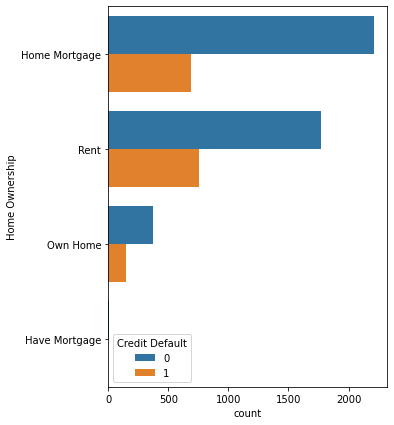

In [23]:
count_plot('Home Ownership', df)

Так как количество значений 'Have Mortgage' слишком мало, указали ему похожее значение 'Home Mortgage'

In [24]:
df.loc[df['Home Ownership']=='Have Mortgage', 'Home Ownership'] = 'Home Mortgage'

#### Years in current job

In [25]:
print("Тип атрибута:", df['Years in current job'].dtype) 
print("Количество незаполненных значений:", 
      df.loc[(df['Years in current job']==''), 'Years in current job'].count())

Тип атрибута: object
Количество незаполненных значений: 0


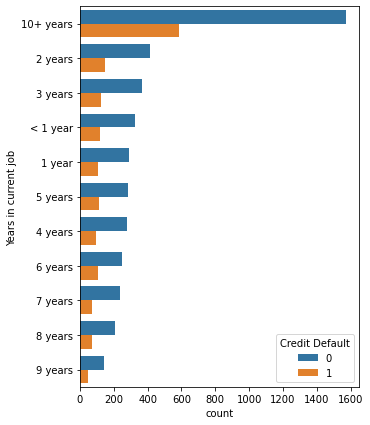

In [26]:
count_plot('Years in current job', df)

Сделаем преобразование и поменяем тип данных на int

In [27]:
df.loc[(df['Years in current job']=='< 1 year'), 'Years in current job'] = '0 year' 
df['Years in current job'] = df['Years in current job'].str.extract(r'(\d+)').astype('int64') + 1

#### Term

In [28]:
print("Тип атрибута:", df['Term'].dtype) 
print("Количество незаполненных значений:", df.loc[(df['Term']==''), 'Term'].count())

Тип атрибута: object
Количество незаполненных значений: 0


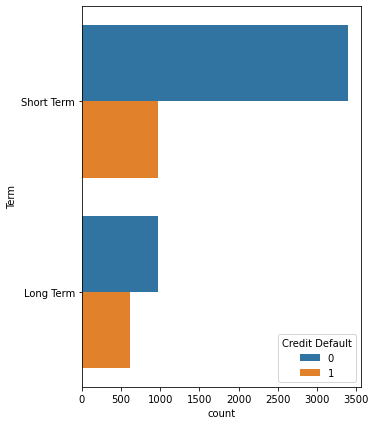

In [29]:
count_plot('Term', df)

Доля клиентов с краткосрочными кредитами гораздо больше, чем с долгосрочными

#### Purpose 

In [30]:
print("Тип атрибута:", df['Purpose'].dtype) 
print("Количество незаполненных значений:", df.loc[(df['Purpose']==''), 'Purpose'].count())

Тип атрибута: object
Количество незаполненных значений: 0


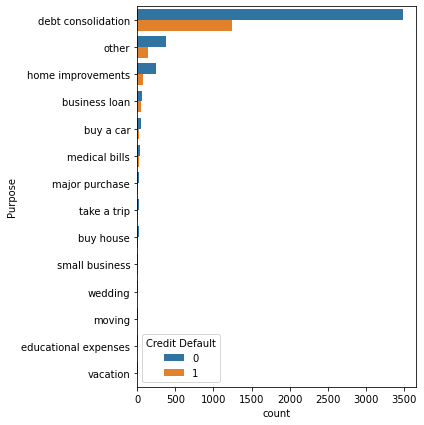

In [31]:
count_plot('Purpose', df)

В дальнейшем с помощью rare-encoder объединим редкие значения в одну группу

### Числовые признаки

In [32]:
#Датафреим, показывающий значение выбросов числовых признаков
data_out = data_outlier(df)
data_out

,нижняя граница,верхняя граница,количество выбросов
name,,,
Id,-3686.75,11223.25,0.0
Annual Income,-349353.00,2833831.00,287.0
Years in current job,-6.50,21.50,0.0
Tax Liens,0.00,0.00,106.0
Number of Open Accounts,-1.00,23.00,138.0
Years of Credit History,1.05,34.25,181.0
Maximum Open Credit,-494670.00,1565762.00,370.0
Number of Credit Problems,0.00,0.00,816.0
Months since last delinquent,-32.50,99.50,1.0


#### Tax Liens

In [33]:
print("Тип атрибута:", df['Tax Liens'].dtype) 
print("Количество уникальных значений:", df['Tax Liens'].nunique())
print("\nДанные по выбросам:")
print(data_out.loc['Tax Liens'])

Тип атрибута: float64
Количество уникальных значений: 8

Данные по выбросам:
нижняя граница           0.0
верхняя граница          0.0
количество выбросов    106.0
Name: Tax Liens, dtype: float64


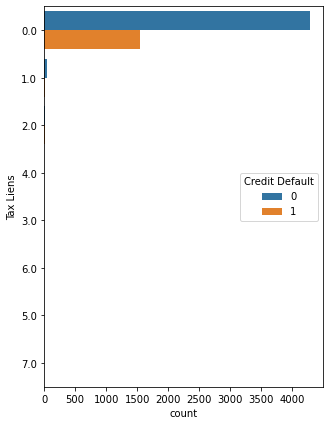

In [34]:
count_plot('Tax Liens', df)

Почти все записи имеют значение 0. Не имеет смысла рассматривать данный признак, удалим его

In [35]:
df = df.drop('Tax Liens', axis=1)

#### Number of Credit Problems

In [36]:
print("Тип атрибута:", df['Number of Credit Problems'].dtype)
print("Количество уникальных значений:", df['Number of Credit Problems'].nunique())
print("\nДанные по выбросам:")
print(data_out.loc['Number of Credit Problems'])

Тип атрибута: float64
Количество уникальных значений: 8

Данные по выбросам:
нижняя граница           0.0
верхняя граница          0.0
количество выбросов    816.0
Name: Number of Credit Problems, dtype: float64


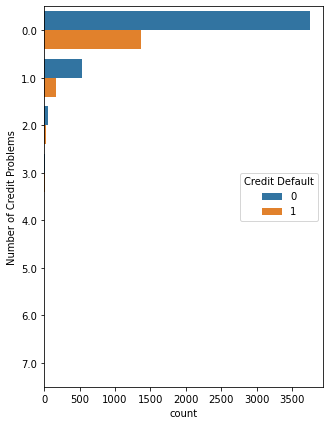

In [37]:
count_plot('Number of Credit Problems', df)

Изменим тип атрибута на object, с помощью rare-encoder объединим редкие значения в одну группу

In [38]:
df['Number of Credit Problems'] = df['Number of Credit Problems'].astype('object') 

#### Bankruptcies

In [39]:
print("Тип атрибута:", df['Bankruptcies'].dtype)
print("Количество уникальных значений:", df['Bankruptcies'].nunique())
print("\nДанные по выбросам:")
print(data_out.loc['Bankruptcies'])

Тип атрибута: float64
Количество уникальных значений: 5

Данные по выбросам:
нижняя граница           0.0
верхняя граница          0.0
количество выбросов    654.0
Name: Bankruptcies, dtype: float64


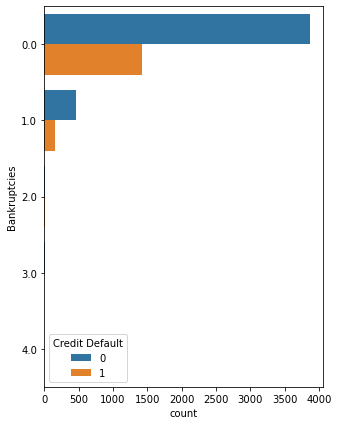

In [40]:
count_plot('Bankruptcies', df)

In [41]:
df['Bankruptcies'] = df['Bankruptcies'].astype('object') 

Значение 0 преобладает над остальными. Изменим тип атрибута на object, с помощью rare-encoder объединим редкие значения в одну группу

#### Annual Income

In [42]:
print("Тип атрибута:", df['Annual Income'].dtype)
print("Количество уникальных значений:", df['Annual Income'].nunique())
print("\nДанные по выбросам:")
print(data_out.loc['Annual Income'])

Тип атрибута: float64
Количество уникальных значений: 5478

Данные по выбросам:
нижняя граница         -349353.0
верхняя граница        2833831.0
количество выбросов        287.0
Name: Annual Income, dtype: float64


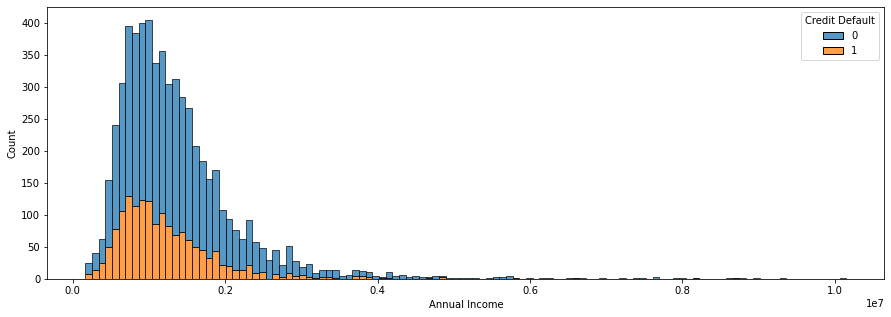

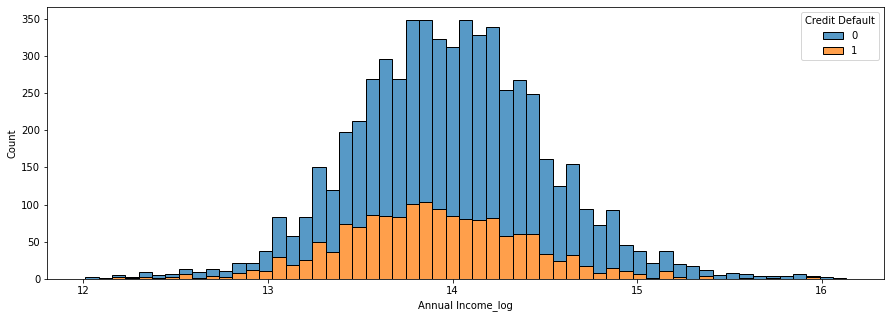

In [43]:
hist_plot('Annual Income', df)

Распределение имеет очень сильный хвост, удалим значения атрибута < 10_000_000 и создадим логарим признака в виде нового признака

In [44]:
df = df[df['Annual Income']< 10_000_000]

In [45]:
df['Annual Income log'] = np.log(df['Annual Income'] + 1)

#### Number of Open Accounts

In [46]:
print("Тип атрибута:", df['Number of Open Accounts'].dtype)
print("Количество уникальных значений:", df['Number of Open Accounts'].nunique())
print("\nДанные по выбросам:")
print(data_out.loc['Number of Open Accounts'])

Тип атрибута: float64
Количество уникальных значений: 39

Данные по выбросам:
нижняя граница          -1.0
верхняя граница         23.0
количество выбросов    138.0
Name: Number of Open Accounts, dtype: float64


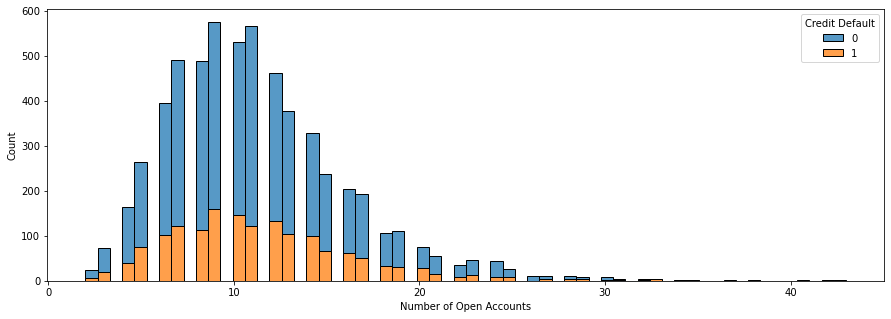

In [47]:
hist_plot('Number of Open Accounts', df)

Создадим новый признак как разбиение исходного на бины

In [48]:
df['Open Accounts bins'] = pd.qcut(df['Number of Open Accounts'], q=[0, .2, .4, .6, .8, 1], 
                                  labels=["bin1", "bin2", "bin3", "bin4", "bin5"]).astype('object')

#### Years of Credit History

In [49]:
print("Тип атрибута:", df['Years of Credit History'].dtype)
print("Количество уникальных значений:", df['Years of Credit History'].nunique())
print("\nДанные по выбросам:")
print(data_out.loc['Years of Credit History'])

Тип атрибута: float64
Количество уникальных значений: 393

Данные по выбросам:
нижняя граница           1.05
верхняя граница         34.25
количество выбросов    181.00
Name: Years of Credit History, dtype: float64


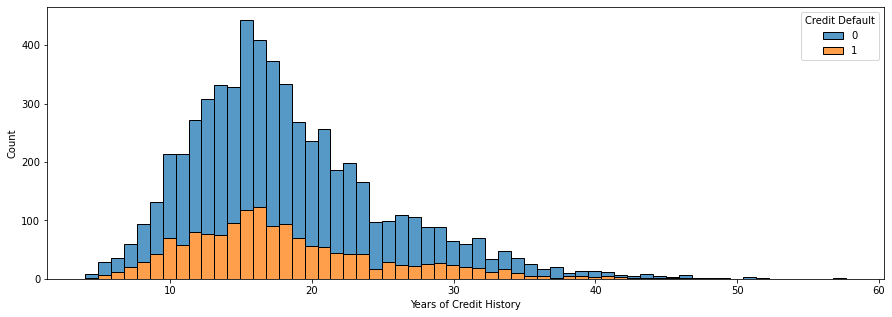

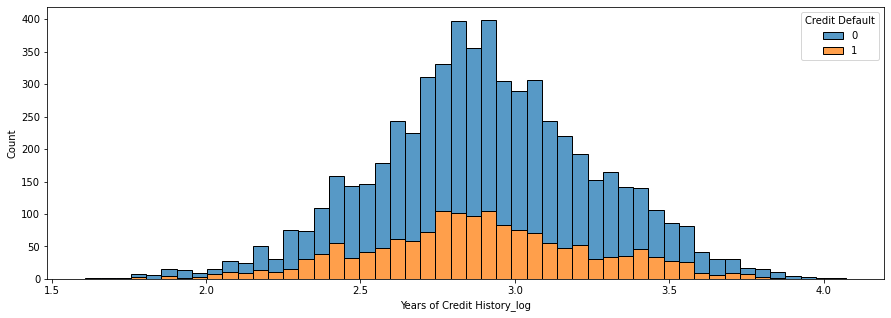

In [50]:
hist_plot('Years of Credit History', df)

Cделаем новый признак логарифмированием

In [51]:
df['Years of Credit History log'] = np.log(df['Years of Credit History'] + 1)

#### Maximum Open Credit

In [52]:
print("Тип атрибута:", df['Maximum Open Credit'].dtype)
print("Количество уникальных значений:", df['Maximum Open Credit'].nunique())
print("\nДанные по выбросам:")
print(data_out.loc['Maximum Open Credit'])

Тип атрибута: float64
Количество уникальных значений: 5587

Данные по выбросам:
нижняя граница         -494670.0
верхняя граница        1565762.0
количество выбросов        370.0
Name: Maximum Open Credit, dtype: float64


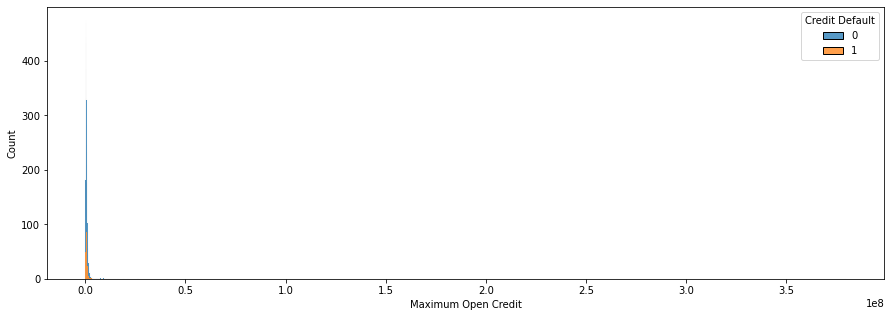

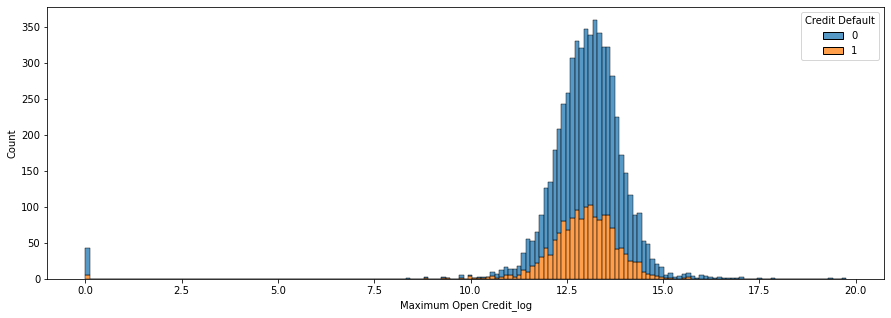

In [53]:
hist_plot('Maximum Open Credit', df)

Посмотрим распределение по значениям больше 0 и меньше 20_000_000

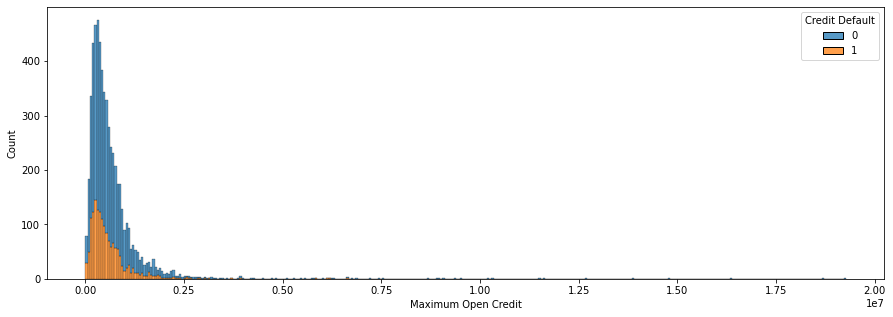

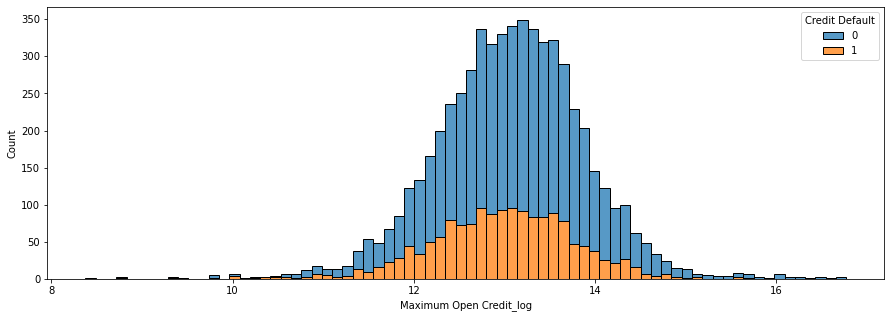

In [54]:
hist_plot('Maximum Open Credit', df[(df['Maximum Open Credit']>0) & (df['Maximum Open Credit']<20_000_000)])

Распределение имеет сильный хвост, удалим значения атрибута < 20_000_000 и создадим логарим признака в виде нового признака

In [55]:
df = df[(df['Maximum Open Credit']>0) & (df['Maximum Open Credit']<20_000_000)]

In [56]:
df['Maximum Open Credit log'] = np.log(df['Maximum Open Credit'] + 1)

#### Months since last delinquent

In [57]:
print("Тип атрибута:", df['Months since last delinquent'].dtype)
print("Количество уникальных значений:", df['Months since last delinquent'].nunique())
print("Количество NULL значений:", df['Months since last delinquent'].isna().sum())
print("\nДанные по выбросам:")
print(data_out.loc['Months since last delinquent'])

Тип атрибута: float64
Количество уникальных значений: 89
Количество NULL значений: 3186

Данные по выбросам:
нижняя граница        -32.5
верхняя граница        99.5
количество выбросов     1.0
Name: Months since last delinquent, dtype: float64


Значение NULL имеет сильное преобладание над остальными значениями, создадим новый атрибут 'With delinquent', текущий признак удалим 

In [58]:
df['With delinquent'] = df['Months since last delinquent'].apply(lambda x: 0 if pd.isna(x) else 1)
df = df.drop('Months since last delinquent', axis=1)

#### Current Loan Amount

In [59]:
print("Тип атрибута:", df['Current Loan Amount'].dtype)
print("Количество уникальных значений:", df['Current Loan Amount'].nunique())
print("\nДанные по выбросам:")
print(data_out.loc['Current Loan Amount'])

Тип атрибута: float64
Количество уникальных значений: 4287

Данные по выбросам:
нижняя граница         -348183.0
верхняя граница        1083313.0
количество выбросов        870.0
Name: Current Loan Amount, dtype: float64


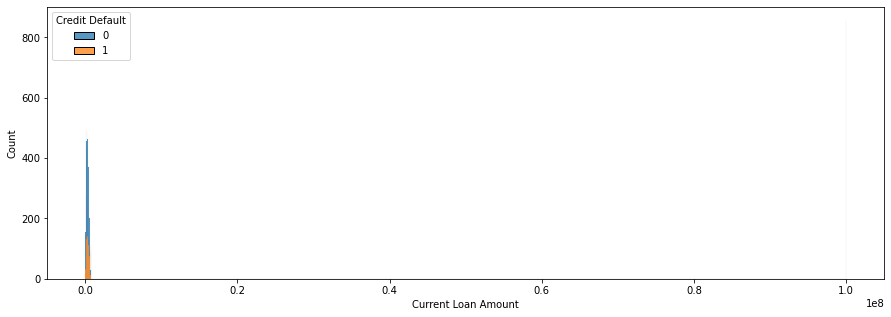

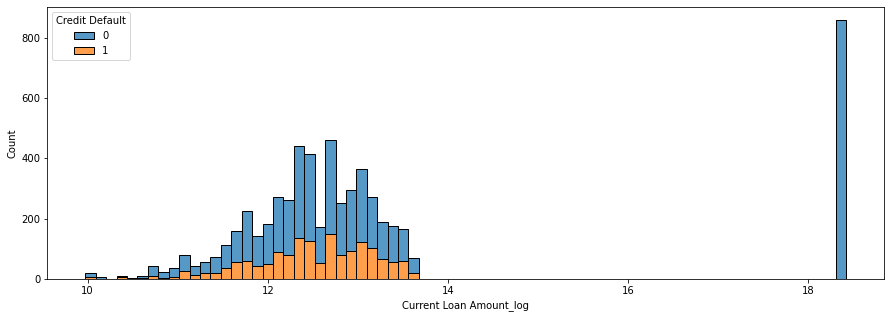

In [60]:
hist_plot('Current Loan Amount', df)

Так как часть значений 99999999.0 (возможно это заглушка), посмотрим распределение < 99_999_999

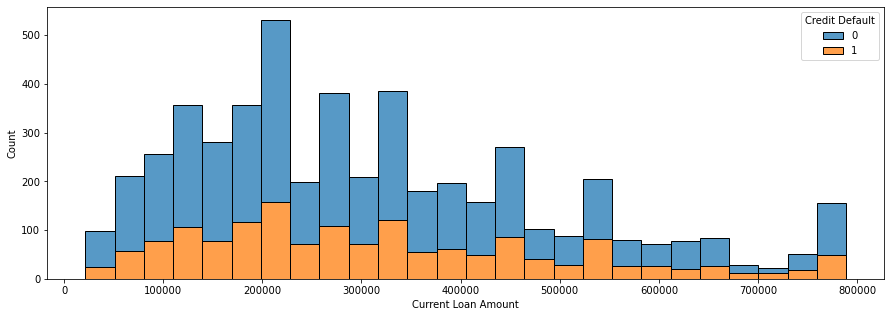

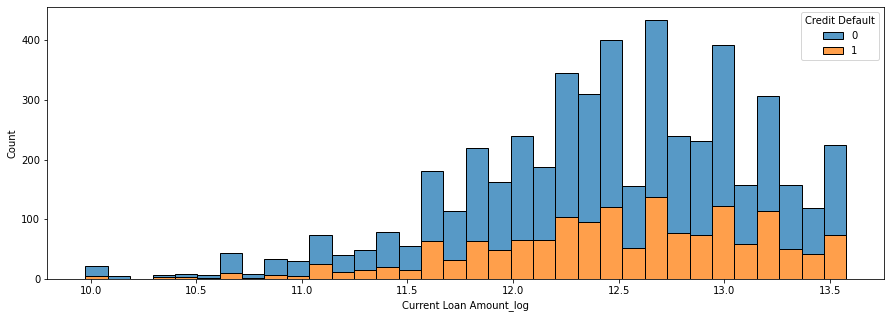

In [61]:
hist_plot('Current Loan Amount', df[df['Current Loan Amount'] < 99_999_999])

Оставим строки, в которых значение признака < 99_999_999

In [62]:
df = df[df['Current Loan Amount'] < 99_999_999]

#### Current Credit Balance

In [63]:
print("Тип атрибута:", df['Current Credit Balance'].dtype)
print("Количество уникальных значений:", df['Current Credit Balance'].nunique())
print("\nДанные по выбросам:")
print(data_out.loc['Current Credit Balance'])

Тип атрибута: float64
Количество уникальных значений: 4628

Данные по выбросам:
нижняя граница        -256229.25
верхняя граница        732036.75
количество выбросов       338.00
Name: Current Credit Balance, dtype: float64


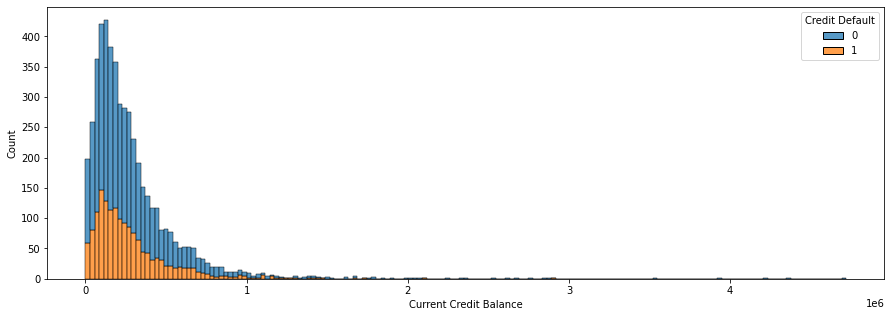

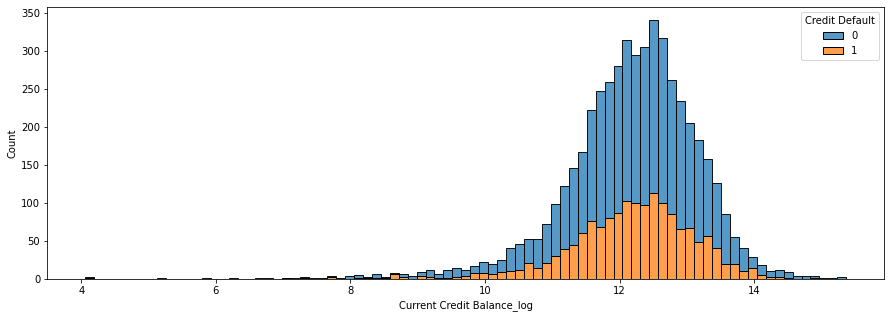

In [64]:
hist_plot('Current Credit Balance', df)

Создадим новый признак логарифмированием

In [65]:
df['Current Credit Balance log'] = np.log(df['Current Credit Balance'] + 1)

#### Monthly Debt

In [66]:
print("Тип атрибута:", df['Monthly Debt'].dtype)
print("Количество уникальных значений:", df['Monthly Debt'].nunique())
print("\nДанные по выбросам:")
print(data_out.loc['Monthly Debt'])

Тип атрибута: float64
Количество уникальных значений: 4658

Данные по выбросам:
нижняя граница        -10521.25
верхняя граница        44380.75
количество выбросов      192.00
Name: Monthly Debt, dtype: float64


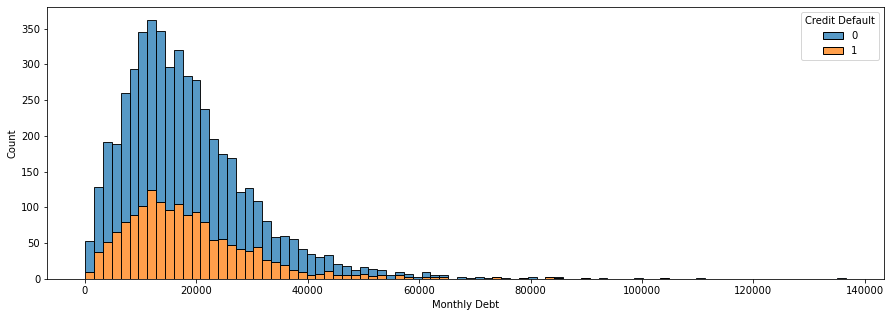

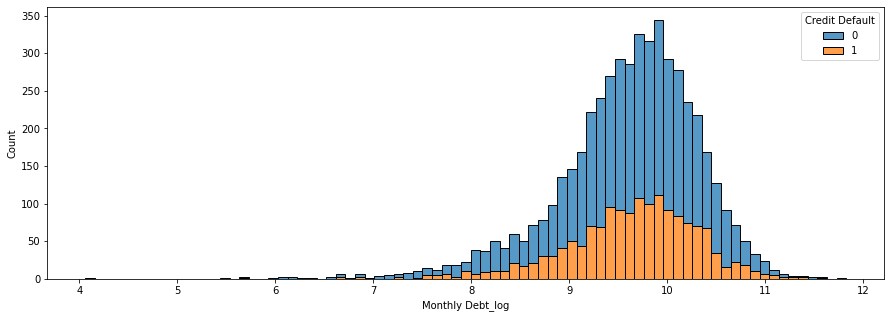

In [67]:
hist_plot('Monthly Debt', df)

Создадим новый признак логарифмированием

In [68]:
df['Monthly Debt log'] = np.log(df['Monthly Debt'] + 1)

#### Credit Score

In [69]:
print("Тип атрибута:", df['Credit Score'].dtype)
print("Количество уникальных значений:", df['Credit Score'].nunique())
print("\nДанные по выбросам:")
print(data_out.loc['Credit Score'])

Тип атрибута: float64
Количество уникальных значений: 266

Данные по выбросам:
нижняя граница         663.0
верхняя граница        791.0
количество выбросов    662.0
Name: Credit Score, dtype: float64


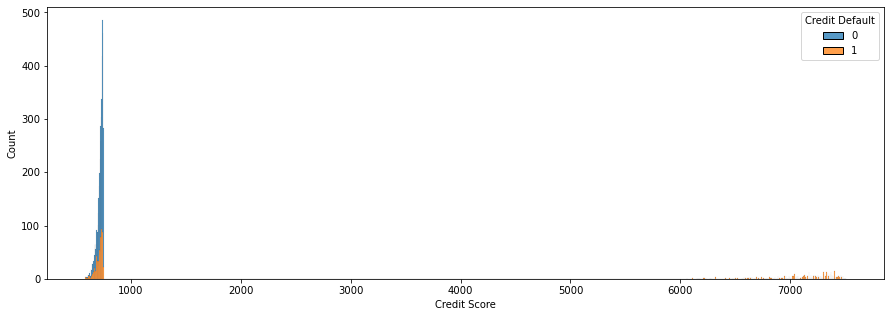

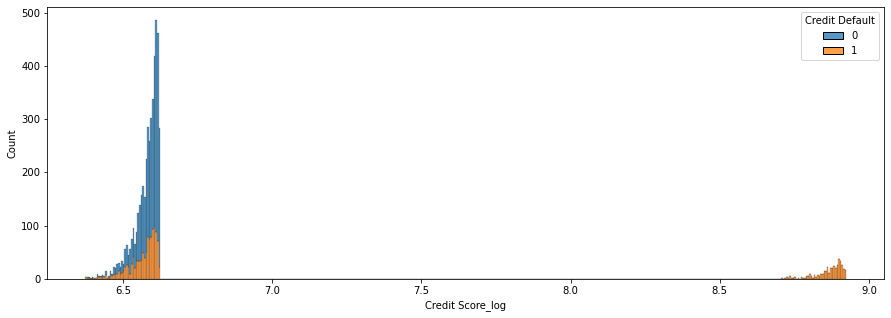

In [70]:
hist_plot('Credit Score', df)

Посмотрим, как распределены значения дефолта у скоров больше 6000

In [71]:
df.loc[(df['Credit Score'] >= 6000),'Credit Default'].value_counts()

1    400
Name: Credit Default, dtype: int64

Часть скоров имеет значение > 6000. Скорее всего это ошибка в вычислении скора 
(она может быть не более 1000, и чем больше скор, тем лучше занчение дефолта должно быть, а у всех записей значение дефолта = 1.

Нужно либо сделать преобразвоание, либо просто удалить строки

Замечание: если выборка достаточно большая или доля дефолтов большая, лучше удалить эти значения. Но в данном случае выборка небольшая и доля дефолтов мала, можно оставить эти строки. Также, модели дают лучший результат с оставленными значениями, но разница небольшая 1-3%

In [72]:
# Различные варианты рещения
#df = df[df['Credit Score'] < 6000]
df['Credit Score'] = df['Credit Score'].apply(lambda x: x/10 if x>=6000 else x).astype('int64')

#### Таргет Credit Default

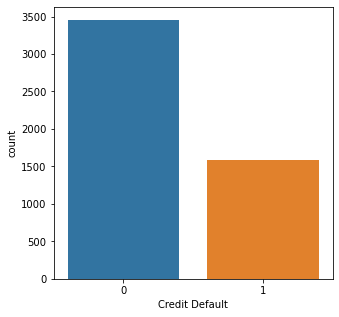

In [73]:
plt.figure(figsize=(5,5))
sns.countplot(x='Credit Default', data=df)
plt.show()

Доля недефолтных записей гораздо больше чем дефолтных

### Создадим новые признаки

## Корреляция признаков

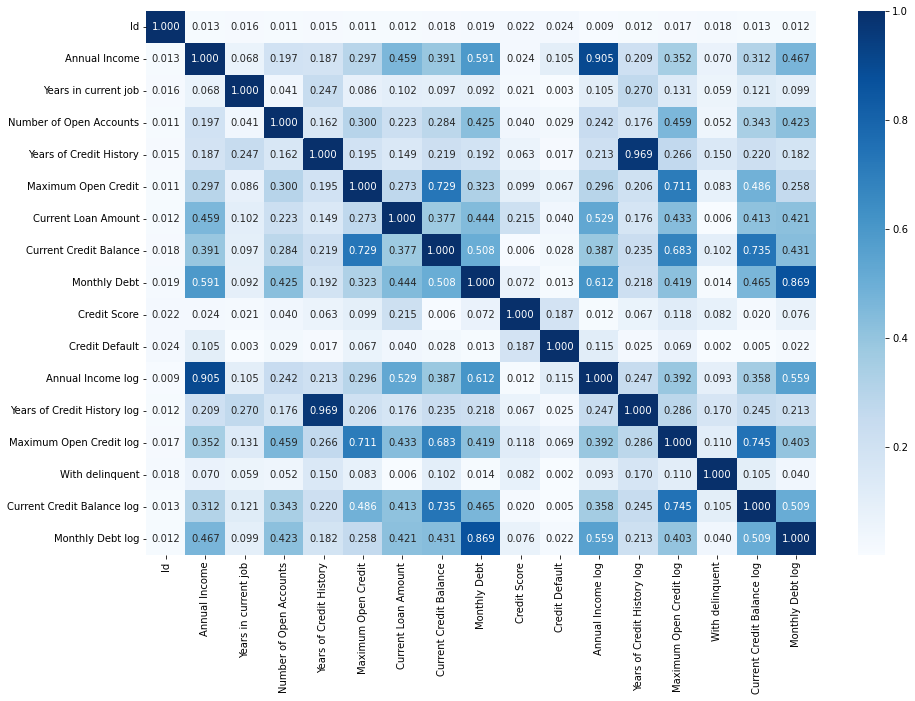

In [74]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr().abs(), annot=True, fmt='.3f', cmap="Blues")
plt.show()

Видим, что часть признаков сильно коррелирует друг с другом удалим часть из них:
        

In [75]:
df = df.drop(['Annual Income', 'Years of Credit History', 'Monthly Debt'], axis=1)

In [76]:
df = df.drop(['Current Credit Balance log'], axis=1)

In [77]:
df = df.drop(['Current Credit Balance'], axis=1)

## Подготовка признаков к моделям

In [78]:
# Выделение типов признаков на категориальные и числовые
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.drop(['Id', 'Credit Default']).to_list()
categorical_features = df.select_dtypes(include=['object']).columns.to_list()

In [79]:
print("Категориальные признаки:", categorical_features, "\nЧисловые признаки:", numeric_features, sep='\n')

Категориальные признаки:
['Home Ownership', 'Number of Credit Problems', 'Bankruptcies', 'Purpose', 'Term', 'Open Accounts bins']

Числовые признаки:
['Years in current job', 'Number of Open Accounts', 'Maximum Open Credit', 'Current Loan Amount', 'Credit Score', 'Annual Income log', 'Years of Credit History log', 'Maximum Open Credit log', 'With delinquent', 'Monthly Debt log']


In [177]:
X = df[[*categorical_features, *numeric_features]]
y = df['Credit Default']

#Выделим трейн и тест
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=RANDOM_SEED)
#Выделим отдельно трейн и валид для корректировки моделей
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=RANDOM_SEED)

#Выделим массивы без обработки для проверки доп критериев
df_train = X_train.copy()
df_test = X_test.copy()
df_val = X_val.copy()

### PSI

In [178]:
print("Значения PSI для числовых признаков\n")
print(f"{'Признак':30}: {'PSI train-test':15} {'PSI train-val':15}")

for var in numeric_features:
    psi_test = calculate_psi(df_train[var], df_test[var])
    psi_val = calculate_psi(df_train[var], df_val[var])
    print(f"{var:30s}: {psi_test:10.4f} {psi_val:15.4f}")

Значения PSI для числовых признаков

Признак                       : PSI train-test  PSI train-val  
Years in current job          :     0.0047          0.0094
Number of Open Accounts       :     0.0079          0.0103
Maximum Open Credit           :     0.0119          0.0064
Current Loan Amount           :     0.0112          0.0103
Credit Score                  :     0.0050          0.0183
Annual Income log             :     0.0091          0.0166
Years of Credit History log   :     0.0062          0.0118
Maximum Open Credit log       :     0.0077          0.0118
With delinquent               :     0.0000          0.0000
Monthly Debt log              :     0.0072          0.0156


### Преобразование признаков

In [179]:
X_train_num = X_train[numeric_features]
X_test_num = X_test[numeric_features]
X_val_num = X_val[numeric_features]

X_train_cat = X_train[categorical_features]
X_test_cat = X_test[categorical_features]
X_val_cat = X_val[categorical_features]

#StandardScaler
stand_scaler = StandardScaler()
X_train_num = stand_scaler.fit_transform(X_train_num)
X_test_num = stand_scaler.transform(X_test_num)
X_val_num = stand_scaler.transform(X_val_num)

#RareLabelEncoder
#Все редкие группы переносим в одну
rle = RareLabelEncoder(tol=0.05, n_categories=3, replace_with='Rare')
X_train_cat = rle.fit_transform(X_train_cat, y_train)
X_test_cat = rle.transform(X_test_cat)
X_val_cat = rle.transform(X_val_cat)

#WOEEncoder
#Кодировщик веса доказательств
woe = WOEEncoder(random_state=RANDOM_SEED)
X_train_cat = woe.fit_transform(X_train_cat, y_train)
X_test_cat = woe.transform(X_test_cat)
X_val_cat = woe.transform(X_val_cat)

# Объединим обратно категориальные и числовые наборы
X_train = np.hstack((X_train_num, X_train_cat))
X_test = np.hstack((X_test_num, X_test_cat))
X_val = np.hstack((X_val_num, X_val_cat))

#Оверсемплинг данных, так как классы несбалансированны
oversample = RandomOverSampler(sampling_strategy='minority', random_state=RANDOM_SEED)
#X_over, y_over = oversample.fit_resample(X_train, y_train)
X_train, y_train = oversample.fit_resample(X_train, y_train)

## Модели

### LogisticRegression

In [146]:
#LogisticRegression Модель без оптимизации
#lr_model = LogisticRegression(random_state=RANDOM_SEED).fit(X_train, y_train)
#lr_prb = lr_model.predict_proba(X_test)[:, 1]
#lr_val = lr_model.predict(X_test)

In [147]:
#LogisticRegression Модель с оптимизацией гиперпараметров
lr_model = LogisticRegression(random_state=RANDOM_SEED)

param_grid = [{
    'solver': ['saga'],  
    'penalty': ['l1','l2', 'elasticnet'],
    'C': (1.0, 100),
    'l1_ratio': (0.0, 1.0)
},
{
    'solver': ['liblinear'],  
    'penalty': ['l1','l2'],
    'C': (1.0, 100),
    'l1_ratio': (0.0, 1.0)
}]

#Байесовский оптимизатор гиперпатаметров
opt = BayesSearchCV(
    lr_model,
    param_grid,
    random_state=RANDOM_SEED,
    cv=3
)

In [148]:
opt.fit(X_train, y_train)
opt.best_params_

OrderedDict([('C', 1.3594004182195794),
             ('l1_ratio', 0.8178300196637516),
             ('penalty', 'l1'),
             ('solver', 'saga')])

In [149]:
lr_model = LogisticRegression(**opt.best_params_, random_state=RANDOM_SEED).fit(X_train, y_train)
lr_prb = lr_model.predict_proba(X_test)[:, 1]

#### Feature importance

График, показывающий степень важности признака для модели

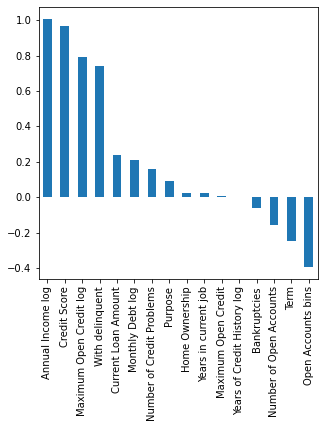

In [150]:
lr_imp = pd.Series(lr_model.coef_[0], index=df_train.columns)

plt.figure(figsize=(5,5))
lr_imp.sort_values(ascending=False).plot.bar()
plt.show()

#### Оценка качества модели

##### AUC значение и кривая ROC_AUC

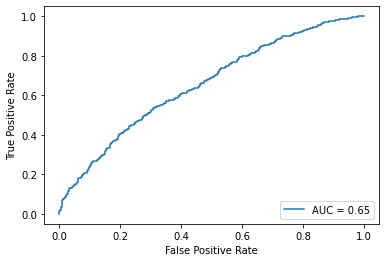

In [171]:
fpr, tpr, threshold = roc_curve(y_test, lr_prb)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)

display.plot()
plt.show()

##### Индекс Джини и интервальный Джини

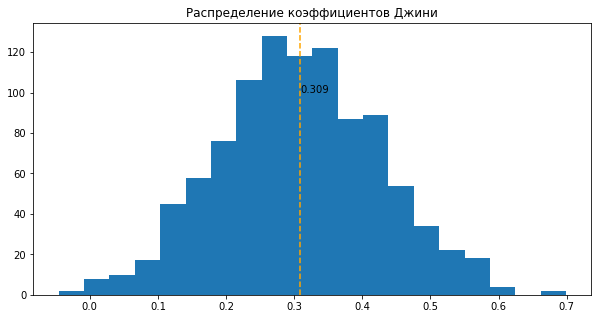

In [172]:
gini_x = round(2*roc_auc_score(y_test, lr_prb) - 1, 3)
gini_interv = interval_gini(y_test, lr_prb)

#Построим график распределения индексов Джини
plot_gini_interv(gini_x, gini_interv)

Судя по распределению индексов Джини, общее значение Джини корректное, может использоваться

##### Тест Колмогорова-Смирнова

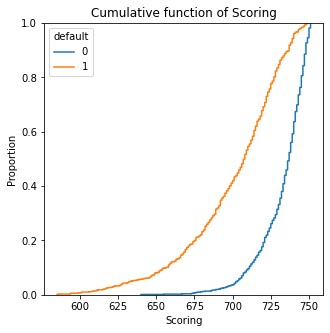

Результат КС теста:


KstestResult(statistic=0.5280481146862507, pvalue=2.7526011202094073e-98)

In [173]:
model_ks_test(lr_prb, df_test)

Вывод:

#### Изотоническая калибровка и график сравнения

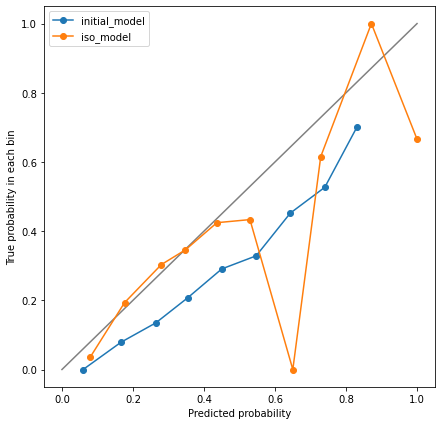

In [175]:
model_calibr_curve(lr_model, lr_prb, y_test, X_val, y_val)

Замечание: Изотоническая регрессия показывается на части значений результат хуже, чем исходная модель

### SVM модель

In [ ]:
#SVM Модель без оптимизации
svc_model = SVC(probability=True, random_state=RANDOM_SEED).fit(X_train, y_train)
svc_prb = svc_model.predict_proba(X_test)[:, 1]

In [192]:
#SVM Модель с оптимизацией гиперпараметров
svc_model = SVC(probability=True, random_state=RANDOM_SEED)

param_grid = {
    'C': (1e-4, 100.0),
    'degree': (1, 5),
    'gamma':['scale', 'auto']
}

#Байесовский оптимизатор гиперпатаметров
opt = BayesSearchCV(
    svc_model,
    param_grid,
    random_state=RANDOM_SEED,
    cv=3
)

In [193]:
opt.fit(X_train, y_train)
opt.best_params_

In [183]:
svc_model = SVC(**opt.best_params_, probability=True, random_state=RANDOM_SEED).fit(X_train, y_train)
svc_prb = svc_model.predict_proba(X_test)[:, 1]

#### Feature importance

In [194]:
if svc_model.kernel == 'linear':
    svc_imp = pd.Series(svc_model.coef_, index=df_train.columns)

    plt.figure(figsize=(5,5))
    svc_imp.sort_values(ascending=False).plot.bar()
    plt.show()
else:
    print("Feature importance работает только для SVM с линейным kernel")

Feature importance работает только для SVM с линейным kernel


#### Оценка качества модели

##### AUC значение и кривая ROC_AUC

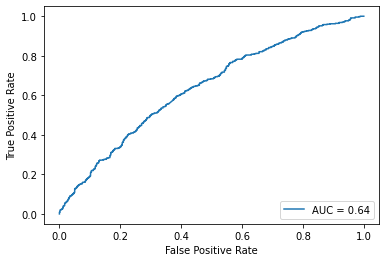

In [195]:
fpr, tpr, threshold = roc_curve(y_test, svc_prb)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)

display.plot()
plt.show()

##### Индекс Джини и интервальный Джини

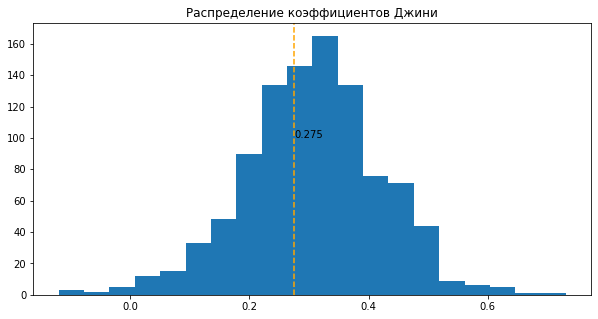

In [196]:
gini_x = round(2*roc_auc_score(y_test, svc_prb) - 1, 3)
gini_interv = interval_gini(y_test, svc_prb)

#Построим график распределения индексов Джини
plot_gini_interv(gini_x, gini_interv)

##### Тест Колмогорова-Смирнова

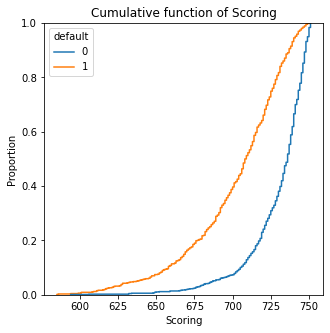

Результат КС теста:


KstestResult(statistic=0.4459550950159815, pvalue=3.3306690738754696e-16)

In [197]:
model_ks_test(svc_prb, df_test)

#### Изотоническая калибровка и график сравнения

In [198]:
model_calibr_curve(svc_model, svc_prb, y_test, X_val, y_val)

NotFittedError: This SVC instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

### Random Forest

In [151]:
#RandomForestClassifier Модель без оптимизации
#rfc_model = RandomForestClassifier(random_state=RANDOM_SEED).fit(X_train, y_train)
#rfc_prb = rfc_model.predict_proba(X_test)[:, 1]

In [116]:
#RandomForestClassifier Модель с оптимизацией гиперпараметров
rfc_model = RandomForestClassifier(random_state=RANDOM_SEED)

param_grid = {
        'n_estimators': (5,500),
        'max_features': ['auto','sqrt', 'log2', None],
        'max_depth': (2,100),
        'min_samples_split': (2,10)
}

#Байесовский оптимизатор гиперпатаметров
opt = BayesSearchCV(
    rfc_model,
    param_grid,
    random_state=RANDOM_SEED,
    cv=3
)

In [118]:
opt.fit(X_train, y_train)
opt.best_params_

In [85]:
rfc_model = RandomForestClassifier(**opt.best_params_, random_state=RANDOM_SEED).fit(X_train, y_train)
rfc_prb = rfc_model.predict_proba(X_test)[:, 1]

#### Feature importance Gini

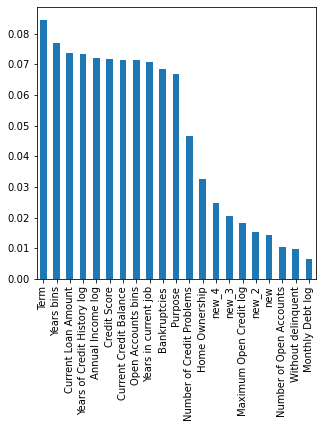

In [152]:
#Gini importance
rfc_imp = pd.Series(rfc_model.feature_importances_, index=df_train.columns)

plt.figure(figsize=(5,5))
rfc_imp.sort_values(ascending=False).plot.bar()
plt.show()

#### Оценка качества модели

#### roc_auc и ROC curve

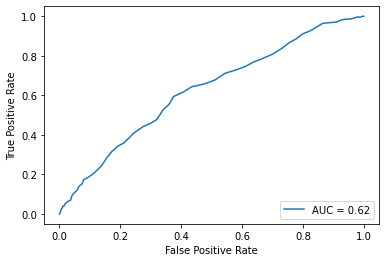

In [153]:
#roc_auc и ROC curve

fpr, tpr, threshold = roc_curve(y_test, rfc_prb)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)

display.plot()
plt.show()

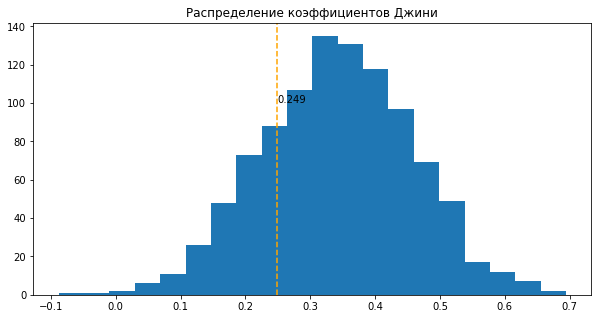

In [154]:
#### Индекс Джини и интервальный Джини

# Коэффициент Джини и интервальный Джини
#gini_interv = interval_gini_old(lr_prb) #это некорректный джини

gini_x = round(2*roc_auc_score(y_test, rfc_prb) - 1, 3)
gini_interv = interval_gini(y_test, rfc_prb)

#Построим график распределения индексов Джини
plt.figure(figsize=(10,5))
plt.hist(gini_interv, bins=20)
plt.axvline(x=gini_x, color='orange', linestyle="--") 
plt.text (gini_x, 100, gini_x)
plt.title('Распределение коэффициентов Джини')
plt.show()

#### Оценка Колмогорова-Смирнова

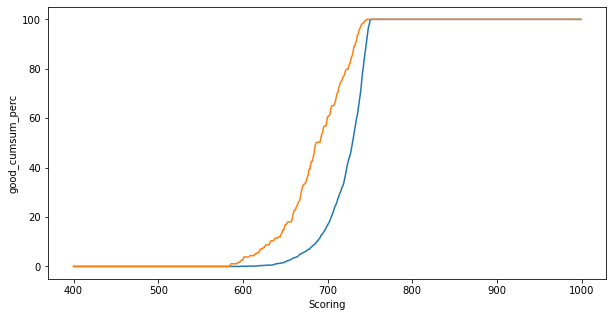

KstestResult(statistic=0.105, pvalue=0.00266241468845588)

In [155]:
model_ks_test(rfc_prb, df_test)

#### Изотоническая калибровка и график сравнения

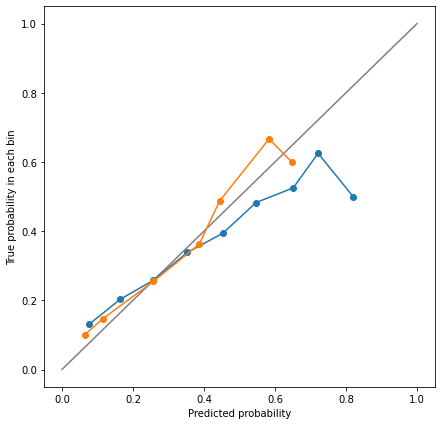

In [156]:
model_calibr_curve(rfc_model, rfc_prb, y_test, X_val, y_val)

### LGBMClassifier

In [157]:
#LGBMClassifier Модель без оптимизации
lgbmc_model = LGBMClassifier(importance_type='gain', random_state=RANDOM_SEED).fit(X_train, y_train)
lgbmc_prb = lgbmc_model.predict_proba(X_test)[:, 1]

In [152]:
#LGBMClassifier Модель с оптимизацией гиперпараметров
lgbmc_model = LGBMClassifier(importance_type='gain', random_state=RANDOM_SEED)

param_grid = {
        'n_estimators': (10, 500),
        'learning_rate': (0.001, 1.0, 'log-uniform'),
        'max_depth': (2, 100),
        'reg_alpha': (0, 10),
        'reg_lambda': (0, 100)
}

opt = BayesSearchCV(
    lgbmc_model,
    param_grid,
    random_state=RANDOM_SEED,
    cv=3
)

In [153]:
opt.fit(X_train, y_train)
opt.best_params_

OrderedDict([('learning_rate', 0.02160217783087772),
             ('max_depth', 92),
             ('n_estimators', 61),
             ('reg_alpha', 4),
             ('reg_lambda', 19)])

In [155]:
lgbmc_model = LGBMClassifier(**opt.best_params_, importance_type='gain', random_state=RANDOM_SEED).fit(X_train, y_train)
lgbmc_prb = lgbmc_model.predict_proba(X_test)[:, 1]

#### Feature importance Gain (Gini)

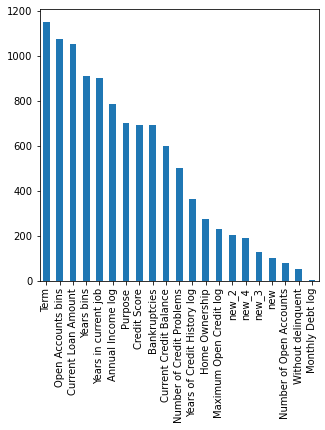

In [158]:
lgbmc_imp = pd.Series(lgbmc_model.feature_importances_, index=df_train.columns)

plt.figure(figsize=(5,5))
lgbmc_imp.sort_values(ascending=False).plot.bar()
plt.show()

#### Оценка качества модели

#### roc_auc и ROC curve

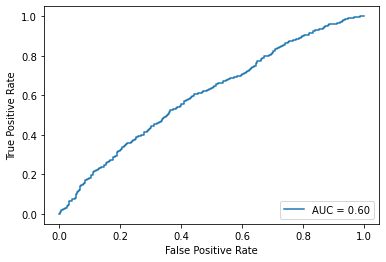

In [159]:
#roc_auc и ROC curve

fpr, tpr, threshold = roc_curve(y_test, lgbmc_prb)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)

display.plot()
plt.show()

#### Коэффициент Джини и интервальный Джини

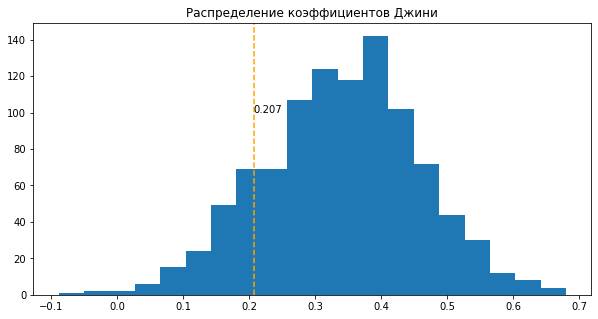

In [160]:
# Коэффициент Джини и интервальный Джини
#gini_interv = interval_gini_old(svc_prb) #это некорректный джини

gini_x = round(2*roc_auc_score(y_test, lgbmc_prb) - 1, 3)
gini_interv = interval_gini(y_test, lgbmc_prb)

#Построим график распределения индексов Джини
plt.figure(figsize=(10,5))
plt.hist(gini_interv, bins=20)
plt.axvline(x=gini_x, color='orange', linestyle="--") 
plt.text (gini_x, 100, gini_x)
plt.title('Распределение коэффициентов Джини')
plt.show()

#### Оценка Колмогорова-Смирнова

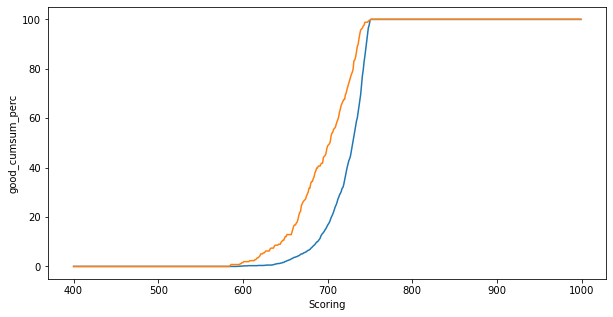

KstestResult(statistic=0.085, pvalue=0.026161496837300326)

In [161]:
model_ks_test(lgbmc_prb, df_test)

#### Изотоническая калибровка и график сравнения

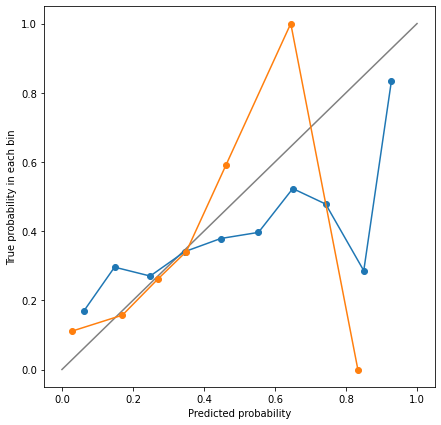

In [162]:
model_calibr_curve(lgbmc_model, lgbmc_prb, y_test, X_val, y_val)